# Assignment 3

### Imports

In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import dual_annealing, curve_fit
from scipy.integrate import solve_ivp, odeint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from numba import jit, njit, prange
import math
import os
import random
import logging
from collections import Counter

### Setup

In [2]:
SEED = 33
np.random.seed(SEED)

os.makedirs('media', exist_ok=True)
logging.basicConfig(level=logging.ERROR)

if not os.path.isfile('predator-prey-data.csv'):
    raise FileNotFoundError("File 'predator-prey-data.csv' not found.")

DATA = pd.read_csv('predator-prey-data.csv').drop(columns=['Unnamed: 0'])
DATA_T, DATA_X, DATA_Y = DATA['t'].to_numpy(), DATA['x'].to_numpy(), DATA['y'].to_numpy()

### Constants

In [3]:
LOW_PARAM_BOUND = 0
UP_PARAM_BOUND = 2
MAX_STEPS_HILLCLIMING = 500
MAX_ITER_SA = 100

### Initial dataset

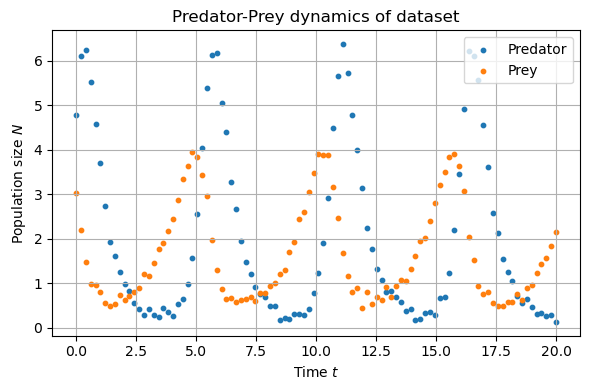

In [4]:
plt.figure(figsize=(6, 4), layout='tight')
plt.scatter(DATA_T, DATA_X, s=10, label='Predator')
plt.scatter(DATA_T, DATA_Y, s=10, label='Prey')
plt.title('Predator-Prey dynamics of dataset')
plt.xlabel('Time $t$')
plt.ylabel('Population size $N$')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/dataset.png')
plt.show()

### Predator-Prey ODEs

In [5]:
def solve_lv(params, init_conditions, t):
    alpha, beta, gamma, delta = params

    def lv_odes(y, t):
        x, z = y
        dxdt = alpha*x - beta*x*z
        dzdt = delta*x*z - gamma*z
        return np.array([dxdt, dzdt])

    solution = odeint(lv_odes, init_conditions, t)
    return solution

### Optimization algorithms and utility

In [6]:
def get_initial_random_guess(lower_bound=LOW_PARAM_BOUND, upper_bound=UP_PARAM_BOUND):
    alpha = random.uniform(lower_bound, upper_bound)
    beta = random.uniform(lower_bound, upper_bound)
    gamma = random.uniform(lower_bound, upper_bound)
    delta = random.uniform(lower_bound, upper_bound)
    return [alpha, beta, gamma, delta]

def get_neighbors(solution, step_size=0.1):
    """Calculate the neighbors of a solution, given a step size."""
    neighbors = []
    for i in range(len(solution)):
        # Add step_size to the parameter if it doesn't exceed PARAM_MAX
        if solution[i] + step_size <= UP_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] + step_size for j in range(len(solution))])
        # Subtract step_size from the parameter if it doesn't become less than PARAM_MIN
        if solution[i] - step_size >= LOW_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] - step_size for j in range(len(solution))])
    return neighbors


def choose_next_step(loss_function, current_step):
    neighbors = get_neighbors(current_step)
    return min(neighbors, key=loss_function)


def hill_climbing(loss_function, initial_step, max_steps):
    """Perform the Hill Climbing optimization algorithm."""
    current_step = initial_step
    history = [current_step]

    for _ in range(max_steps):
        try:
            next_step = choose_next_step(loss_function, current_step)
            if loss_function(next_step) >= loss_function(current_step):
                break
            history.append(next_step)
            current_step = next_step
        except Exception as e:
            logging.error(f"An error occurred during the hill climbing: {str(e)}")
            break

    return current_step, history

def classic_annealing(*args, **kwargs):
    return dual_annealing(*args, **kwargs, no_local_search=True)

### Objective functions

In [7]:
def mse_objective(params):
    initial_conditions = [DATA_Y[0], DATA_X[0]]
    sim_data = solve_lv(params, initial_conditions, DATA_T)
    mse = mean_squared_error(DATA[['y', 'x']].values, sim_data)
    return mse

def mae_objective(params):
    initial_conditions = [DATA_Y[0], DATA_X[0]]
    sim_data = solve_lv(params, initial_conditions, DATA_T)
    mae = mean_absolute_error(DATA[['y', 'x']].values, np.abs(sim_data))
    return mae

def mse_objective_mod(params, data):
    valid_data = data.dropna(subset=['y', 'x'])
    if valid_data.empty:
        return float('inf')
    
    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, valid_data['t'])
    return mean_squared_error(valid_data[['y', 'x']].values, sim_data)

def mae_objective_mod(params, data):
    valid_data = data.dropna(subset=['y', 'x'])
    if valid_data.empty:
        return float('inf')
    
    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, valid_data['t'])
    return mean_absolute_error(valid_data[['y', 'x']].values, sim_data)

def smape_objective_mod(params, data):
    valid_data = data.dropna(subset=['y', 'x'])
    if valid_data.empty:
        return float('inf')
    
    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, valid_data['t'])
    absolute_percentage_error = 2 * np.abs((sim_data - valid_data[['y', 'x']].values) /
                                           (np.abs(sim_data) + np.abs(valid_data[['y', 'x']].values)))
    return np.nanmean(absolute_percentage_error)

In [8]:
bounds = [(LOW_PARAM_BOUND, UP_PARAM_BOUND)] * 4
initial_guess = get_initial_random_guess()
hc_optimizers = [hill_climbing]
sa_optimizers = [classic_annealing, dual_annealing]
optimizers = hc_optimizers + sa_optimizers
objectives = [mse_objective, mae_objective]
est_params = {opt.__name__: {obj.__name__: [] for obj in objectives} for opt in optimizers}

for obj in objectives:
    for opt in hc_optimizers:
        params, _ = hill_climbing(
            obj, initial_guess, max_steps=MAX_STEPS_HILLCLIMING)
        est_params[opt.__name__][obj.__name__] = params
        logging.info(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")
    for opt in sa_optimizers:
        params = opt(obj, bounds=bounds, maxiter=MAX_ITER_SA).x
        est_params[opt.__name__][obj.__name__] = params
        logging.info(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")

In [ ]:
def plot_comparison_optimizers(hc_optimizers, sa_optimizers, objective=mse_objective, linestyles=['-', '--', ':'], colors=['tab:blue', 'tab:orange']):
    t_detail = np.linspace(0, 20, 1000)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='tight', sharey=True)
    fig.suptitle(f'Comparison of simulations with the experimental dataset by optimization algorithms using {objective.__name__}')
    axs[0].scatter(DATA_T, DATA_X, s=5, label='Predator', color=colors[0])
    axs[0].scatter(DATA_T, DATA_Y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(hc_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [DATA_Y[0], DATA_X[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[0].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[0].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[0].set_title('Hill climbing-optimized model')
    axs[0].set_xlabel('Time $t$')
    axs[0].set_ylabel('Population size $N$')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)
    axs[1].scatter(DATA_T, DATA_X, s=5, label='Predator', color=colors[0])
    axs[1].scatter(DATA_T, DATA_Y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(sa_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [DATA_Y[0], DATA_X[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[1].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[1].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[1].set_title('Simulated annealing-optimized model')
    axs[1].set_xlabel('Time $t$')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)
    plt.savefig('media/comparison_optimizers.png')
    plt.show()

plot_comparison_optimizers(hc_optimizers, sa_optimizers)

Removing samples functionality

In [ ]:
def gen_sample_dataset(data, frac):
    data = data.copy()
    return data.sample(frac=frac).sort_values(by='t').reset_index(drop=True)

def batch_comparison_by_frac(fracs, n_samples=10, optimizer=classic_annealing, objective=mse_objective, initial_conditions=[DATA_Y[0], DATA_X[0]], data=DATA, **kwargs):
    results = []
    with tqdm(total=len(fracs)*n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(objective, **kwargs).x
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                mse.append(mean_squared_error(sample_data[['y', 'x']].values, sim_data))
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
        logging.info(f"params: {params}")
        logging.info(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
        logging.info(f"MSE: {mean_squared_error(sample_data[['y', 'x']].values, sim_data)}")
        
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

def batch_comparison_by_frac_and_variable(data, fracs, data_variable, n_samples=10,
                             optimizer=classic_annealing,
                             objective=mse_objective_mod,
                             **kwargs):
    results = []
    with tqdm(total=len(fracs) * n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(lambda params: objective(params, sample_data), **kwargs).x
                initial_conditions = [sample_data['y'].iloc[0], sample_data['x'].iloc[0]]
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                mse.append(mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]]))
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
        logging.info(f"params: {params}")
        logging.info(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
        logging.info(f"MSE: {mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]])}")
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

In [ ]:
try:
    fracs = np.arange(0.1, 1.0, 0.1)
    experiment_df = batch_comparison_by_frac(fracs=fracs, n_samples=2, bounds=bounds, maxiter=MAX_ITER_SA)
    plt.figure(figsize=(6, 4), layout='tight')
    plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
    plt.fill_between(experiment_df['frac'], experiment_df['conf_int'].apply(lambda x: x[0]), experiment_df['conf_int'].apply(lambda x: x[1]), alpha=0.2, label='95% confidence interval')
    plt.title('Mean and confidence interval of MSE by fraction of dataset')
    plt.xlabel('Fraction of dataset')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig('media/frac_conf_mse_sa.png')
    plt.show()
except Exception as e:
    logging.error(f"An error occurred: {e}")

## Experiments and plots

In [ ]:
for data_variable in ['y', 'x']:
    try:
        experiment_df = batch_comparison_by_frac_and_variable(fracs=fracs, data_variable=data_variable,
                                             n_samples=2, bounds=bounds, maxiter=MAX_ITER_SA,
                                             data=DATA, objective=mse_objective_mod)
        plt.figure(figsize=(6, 4), layout='tight')
        plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
        plt.fill_between(experiment_df['frac'],
                        experiment_df['conf_int'].apply(lambda x: x[0]),
                        experiment_df['conf_int'].apply(lambda x: x[1]),
                        alpha=0.2, label='95% confidence interval')
        plt.title(f'Mean and confidence interval of MSE by fraction of dataset for {data_variable}')
        plt.xlabel('Fraction of dataset')
        plt.ylabel('MSE')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
    except Exception as e:
        logging.error(f"An error occurred: {e}")

In [ ]:
for data_variable in ['y', 'x']:
    try:
        experiment_df = batch_comparison_by_frac_and_variable(fracs=fracs, data_variable='x', 
                                             n_samples=2, bounds=bounds, maxiter=MAX_ITER_SA, 
                                             data=DATA, objective=smape_objective_mod)
        plt.figure(figsize=(6, 4), layout='tight')
        plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
        plt.fill_between(experiment_df['frac'],
                        experiment_df['conf_int'].apply(lambda x: x[0]),
                        experiment_df['conf_int'].apply(lambda x: x[1]),
                        alpha=0.2, label='95% confidence interval')
        plt.title(f'Mean and confidence interval of sMAPE by fraction of dataset for {data_variable}')
        plt.xlabel('Fraction of dataset')
        plt.ylabel('sMAPE')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
    except Exception as e:
        logging.error(f"An error occurred: {e}")

#### How many data-points from each time-series you could remove until you are not able to reverse-engineer the parameters any more?

First, try to find the importance of each time-series on reverse-engineering process by ﬁxing one time-series and removing data-points from the other one. In this way, you will ﬁnd the critical number of data-points for each time-series.

In [ ]:
def prune_data_series(data, variable, frac_to_remove):
    logging.info(f"\nAttempting to prune {frac_to_remove*100}% of '{variable}' data...")
    if not isinstance(frac_to_remove, (float, int)):
        raise TypeError('frac_to_remove should be a float or an integer.')
    if not 0 <= frac_to_remove <= 1:
        raise ValueError('frac_to_remove should be between 0 and 1 inclusive.')

    num_data_to_prune = int(len(data) * frac_to_remove)
    logging.info(f"Number of data points to prune: {num_data_to_prune}")

    pruned_data = data.copy()
    if num_data_to_prune > 0:
        prune_indices = np.random.choice(data.index, size=num_data_to_prune, replace=False)
        pruned_data.loc[prune_indices, variable] = np.nan
        logging.info(f"Pruned data. Remaining data points: {pruned_data.dropna(subset=[variable]).shape[0]}")
    else:
        logging.info("No data points to prune based on the fraction provided.")

    return pruned_data

In [ ]:
def optimize_with_pruned_data(pruned_data, optimizer, objective_function, bounds):
    logging.info("\nOptimizing with pruned data...")
    valid_data = pruned_data.dropna(subset=['y', 'x'])
    if valid_data.shape[0] < 2:
        logging.warning("Not enough data points after pruning to perform optimization.")
        return None, float('inf')

    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    try:
        result = optimizer(lambda params: objective_function(params, valid_data), bounds=bounds, maxiter=MAX_ITER_SA)
        logging.info("Optimization successful.")
        return result.x, result.fun
    except Exception as e:
        logging.error(f"An error occurred during optimization: {e}")
        return None, float('inf')

In [ ]:
# fractions = [round(float(i)/10, 1) for i in range(11)]
fractions = np.arange(0.1, 1.0, 0.1)
# objectives_mod = [mse_objective_mod, mae_objective_mod, smape_objective_mod]
objectives_mod = [mse_objective_mod]
names = ['mse', 'mae', 'smape']
n_sim = 2

with tqdm(total=2*len(fractions)*len(objectives_mod)*n_sim) as pbar:
    for objective, name in zip(objectives_mod, names):
        results = []
        for variable in ['x', 'y']:
            for frac in fractions:
                losses = []
                for n in range(n_sim):
                    pruned_data = prune_data_series(DATA, variable, frac)
                    params, loss = optimize_with_pruned_data(pruned_data, classic_annealing, objective_function=objective, bounds=bounds)
                    losses.append(loss)
                    pbar.update()
                results.append({
                    'variable': variable,
                    'fraction_removed': frac,
                    'loss': np.mean(losses)
                })
        results_df = pd.DataFrame(results)

        for variable in ['x', 'y']:
            variable_results = results_df[results_df['variable'] == variable]
            plt.plot(variable_results['fraction_removed'], variable_results['loss'], label=f'{variable} data pruned')

        plt.xlabel('Fraction of data removed')
        plt.ylabel(f'{name.upper()} after optimization')
        plt.legend()
        plt.title('Impact of Data Pruning on Parameter Estimation')
        plt.grid(True)
        plt.show()

Then, if you combine two reduced time-series, could you still infer the parameters?

Does removing every data-point have the same effect on reverse-engineering process? In other words, what are the points that you could remove safely without affecting the inferance procedure? and what are those with critical effects on the process?

In [22]:
def leave_one_out_analysis(data, initial_guess, bounds, maxiter):
    importance_scores = []

    for i in tqdm(range(len(data)), desc="Analyzing Data Points"):
        # Exclude one data point
        reduced_data = data.drop(index=i)
        t_reduced, x_reduced, y_reduced = reduced_data['t'].to_numpy(), reduced_data['x'].to_numpy(), reduced_data['y'].to_numpy()

        def mse_objective_reduced(params):
            initial_conditions = [y_reduced[0], x_reduced[0]]
            simulated = solve_lv(params, initial_conditions, t_reduced)
            mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
            return mse

        # Fit the model on the reduced dataset
        result = classic_annealing(mse_objective_reduced, bounds=bounds, maxiter=maxiter)
        params = result.x
        mse = mse_objective_reduced(params)
        importance_scores.append((i, mse))

    return importance_scores


mse_list = []
n_sims=10
for sims in range(n_sims):
    importance_scores = leave_one_out_analysis(DATA, initial_guess, bounds, MAX_ITER_SA)
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    mse_list.append(importance_scores[:10])
    
print(mse_list)
# Sort the scores to see which data points had the most impact
importance_df = pd.DataFrame(importance_scores, columns=['Data Point', 'MSE'])

# Sort the DataFrame by 'MSE' in descending order
importance_df = importance_df.sort_values(by='MSE', ascending=False)
importance_df.head(20)

Analyzing Data Points: 100%|█████████████████████████████████████████████████████████| 100/100 [04:45<00:00,  2.85s/it]

[[(39, 0.8457692052582929), (59, 0.7782085311436494), (53, 0.7763183368041391), (12, 0.708956402665202), (60, 0.6275858558007276), (71, 0.6234779124210522), (80, 0.5663412821265881), (89, 0.5644938004184075), (86, 0.5510813745946769), (0, 0.549003807805974)], [(90, 1.037741312280699), (96, 0.8407389999326703), (1, 0.6598371678262652), (80, 0.6596453934449967), (49, 0.6428911424347229), (44, 0.6362249375688878), (26, 0.6084528172152577), (56, 0.6080290804573775), (67, 0.6008975101793009), (9, 0.5916084775233229)], [(60, 0.7284265068982623), (65, 0.6282821007376334), (12, 0.6016028788503257), (19, 0.598163989689452), (35, 0.5617454274304182), (27, 0.5592147704894722), (5, 0.5551209720124775), (30, 0.514308217389085), (16, 0.5108786146008253), (9, 0.5036023284685814)], [(96, 1.0829985302188505), (85, 0.7250008870739857), (75, 0.7231577467901755), (3, 0.7207070623410047), (19, 0.7031128062394276), (52, 0.6656959901237475), (13, 0.6536310766925437), (45, 0.6141340346103085), (91, 0.61336569

,Data Point,MSE
0,38,0.916654
1,76,0.732130
2,7,0.690462
3,99,0.643767
4,65,0.637313
5,25,0.635112
6,90,0.565491
7,55,0.563912
8,64,0.558682
9,61,0.513332


In [37]:
# Flatten the list of MSEs
flat_mse_list = [item for sublist in mse_list for item in sublist]

# Count the frequency of each data point
data_point_frequencies = Counter([datapoint for datapoint, mse in flat_mse_list])
total_entries = len(flat_mse_list)
probability_distribution = {datapoint: freq / total_entries for datapoint, freq in data_point_frequencies.items()}

# Create Dataframe
probability_df = pd.DataFrame(list(probability_distribution.items()), columns=['Data Point', 'Probability'])

probability_df.head()

,Data Point,Probability
0,39,0.02
1,59,0.01
2,53,0.01
3,12,0.02
4,60,0.02


In [45]:
len(probability_df)

64

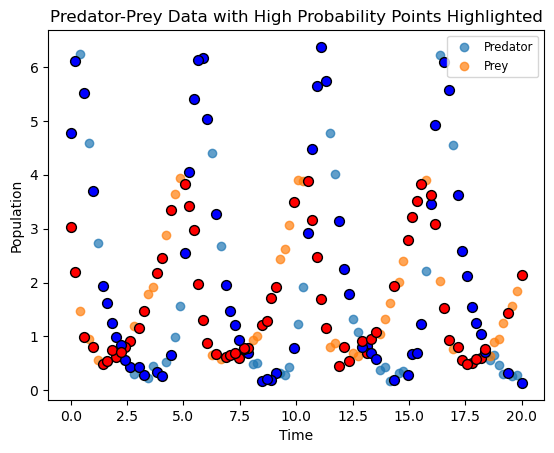

In [46]:
# All points that occur in the probability DF will be highlighted
n_highlight = len(probability_df)

# Sort the DataFrame 
high_probability_indices = probability_df.sort_values(by='Probability', ascending=False).head(n_highlight)['Data Point']

# Plot the original data
plt.scatter(DATA['t'], DATA['x'], label='Predator', alpha=0.7)
plt.scatter(DATA['t'], DATA['y'], label='Prey', alpha=0.7)

# Highlight the points 
for idx in high_probability_indices:
    plt.scatter(DATA.loc[idx, 't'], DATA.loc[idx, 'x'], color='blue', edgecolor='black', s=50 )
    plt.scatter(DATA.loc[idx, 't'], DATA.loc[idx, 'y'], color='red', edgecolor='black', s=50 )

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Data with High Probability Points Highlighted')
plt.legend(loc = "upper right", fontsize = 'small')
plt.savefig('media/high_probability_points_plot.png')
plt.show()


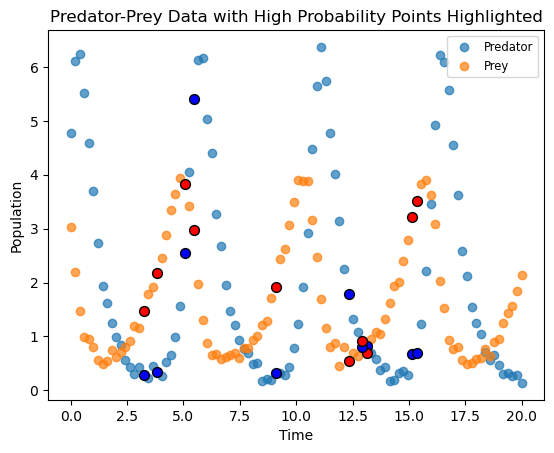

In [47]:
n_highlight = 10

# Plot the original data
plt.scatter(DATA['t'], DATA['x'], label='Predator', alpha=0.7)
plt.scatter(DATA['t'], DATA['y'], label='Prey', alpha=0.7)

# Highlight the points with highest probability
for idx in high_probability_indices:
    plt.scatter(DATA.loc[idx, 't'], DATA.loc[idx, 'x'], color='blue', edgecolor='black', s=50 )
    plt.scatter(DATA.loc[idx, 't'], DATA.loc[idx, 'y'], color='red', edgecolor='black', s=50 )

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Data with High Probability Points Highlighted')
plt.legend(loc = "upper right", fontsize = 'small')
plt.savefig('media/high_probability_points_plot.png')
plt.show()

#### \<Extra question\>